출처 : https://wikidocs.net/86900

In [1]:
import os
import re
import shutil
import zipfile

import numpy as np
import pandas as pd
import tensorflow as tf
import unicodedata
import urllib3
from tensorflow.keras.layers import Embedding, GRU, Dense
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

In [2]:
http = urllib3.PoolManager()
url = 'http://www.manythings.org/anki/fra-eng.zip'
filename = 'fra-eng.zip'
path = os.getcwd()
zipfilename = os.path.join(path, filename)
with http.request('GET', url, preload_content=False) as r, open(zipfilename, 'wb') as out_file:
    shutil.copyfileobj(r, out_file)

with zipfile.ZipFile(zipfilename, 'r') as zip_ref:
    zip_ref.extractall(path)

In [3]:
# 이번 실습에서는 약 19만개의 데이터 중 33,000개의 샘플만을 사용할 예정입니다.

num_samples = 33000

In [4]:
# 전처리 함수들을 구현합니다. 구두점 등을 제거하거나 단어와 구분해주기 위한 전처리입니다.

def to_ascii(s):
  # 프랑스어 악센트(accent) 삭제
  # 예시 : 'déjà diné' -> deja dine
  return ''.join(c for c in unicodedata.normalize('NFD', s)
                   if unicodedata.category(c) != 'Mn')

def preprocess_sentence(sent):
  # 악센트 제거 함수 호출
  sent = to_ascii(sent.lower())

  # 단어와 구두점 사이에 공백 추가.
  # ex) "I am a student." => "I am a student ."
  sent = re.sub(r"([?.!,¿])", r" \1", sent)

  # (a-z, A-Z, ".", "?", "!", ",") 이들을 제외하고는 전부 공백으로 변환.
  sent = re.sub(r"[^a-zA-Z!.?]+", r" ", sent)

  # 다수 개의 공백을 하나의 공백으로 치환
  sent = re.sub(r"\s+", " ", sent)
  return sent

In [5]:
# 구현한 전처리 함수들을 임의의 문장을 입력으로 테스트해봅시다.

# 전처리 테스트
en_sent = u"Have you had dinner?"
fr_sent = u"Avez-vous déjà diné?"

print('전처리 전 영어 문장 :', en_sent)
print('전처리 후 영어 문장 :',preprocess_sentence(en_sent))
print('전처리 전 프랑스어 문장 :', fr_sent)
print('전처리 후 프랑스어 문장 :', preprocess_sentence(fr_sent))

전처리 전 영어 문장 : Have you had dinner?
전처리 후 영어 문장 : have you had dinner ?
전처리 전 프랑스어 문장 : Avez-vous déjà diné?
전처리 후 프랑스어 문장 : avez vous deja dine ?


In [6]:
# 전체 데이터에서 33,000개의 샘플에 대해서 전처리를 수행합니다. 
# 또한 훈련 과정에서 교사 강요(Teacher Forcing)을 사용할 예정이므로, 
# 훈련 시 사용할 디코더의 입력 시퀀스와 실제값. 즉, 레이블에 해당되는 출력 시퀀스를 따로 분리하여 저장합니다. 
# 입력 시퀀스에는 시작을 의미하는 토큰인 <sos>를 추가하고, 출력 시퀀스에는 종료를 의미하는 토큰인 <eos>를 추가합니다.

def load_preprocessed_data():
  encoder_input, decoder_input, decoder_target = [], [], []

  with open("fra.txt", "r") as lines:
    for i, line in enumerate(lines):
      # source 데이터와 target 데이터 분리
      src_line, tar_line, _ = line.strip().split('\t')

      # source 데이터 전처리
      src_line = [w for w in preprocess_sentence(src_line).split()]

      # target 데이터 전처리
      tar_line = preprocess_sentence(tar_line)
      tar_line_in = [w for w in ("<sos> " + tar_line).split()]
      tar_line_out = [w for w in (tar_line + " <eos>").split()]

      encoder_input.append(src_line)
      decoder_input.append(tar_line_in)
      decoder_target.append(tar_line_out)

      if i == num_samples - 1:
        break

  return encoder_input, decoder_input, decoder_target

In [8]:
# 이렇게 얻은 3개의 데이터셋 인코더의 입력, 디코더의 입력, 디코더의 레이블을 상위 5개 샘플만 출력해봅시다.
# sents_fra_in : 교사 강요에 필요한 입력
sents_en_in, sents_fra_in, sents_fra_out = load_preprocessed_data()
print('인코더의 입력 :',sents_en_in[:5])
print('디코더의 입력 :',sents_fra_in[:5])
print('디코더의 레이블 :',sents_fra_out[:5])
# 인코더의 입력 : [['go', '.'], ['go', '.'], ['go', '.'], ['hi', '.'], ['hi', '.']]
# 디코더의 입력 : [['<sos>', 'va', '!'], ['<sos>', 'marche', '.'], ['<sos>', 'bouge', '!'], ['<sos>', 'salut', '!'], ['<sos>', 'salut', '.']]
# 디코더의 레이블 : [['va', '!', '<eos>'], ['marche', '.', '<eos>'], ['bouge', '!', '<eos>'], ['salut', '!', '<eos>'], ['salut', '.', '<eos>']]

인코더의 입력 : [['go', '.'], ['go', '.'], ['go', '.'], ['hi', '.'], ['hi', '.']]
디코더의 입력 : [['<sos>', 'va', '!'], ['<sos>', 'marche', '.'], ['<sos>', 'bouge', '!'], ['<sos>', 'salut', '!'], ['<sos>', 'salut', '.']]
디코더의 레이블 : [['va', '!', '<eos>'], ['marche', '.', '<eos>'], ['bouge', '!', '<eos>'], ['salut', '!', '<eos>'], ['salut', '.', '<eos>']]


In [9]:
# 케라스 토크나이저를 통해 단어 집합을 생성, 정수 인코딩을 진행 후 이어서 패딩을 진행합니다.

tokenizer_en = Tokenizer(filters="", lower=False)
tokenizer_en.fit_on_texts(sents_en_in)
encoder_input = tokenizer_en.texts_to_sequences(sents_en_in)
encoder_input = pad_sequences(encoder_input, padding="post")

tokenizer_fra = Tokenizer(filters="", lower=False)
tokenizer_fra.fit_on_texts(sents_fra_in)
tokenizer_fra.fit_on_texts(sents_fra_out)

decoder_input = tokenizer_fra.texts_to_sequences(sents_fra_in)
decoder_input = pad_sequences(decoder_input, padding="post")

decoder_target = tokenizer_fra.texts_to_sequences(sents_fra_out)
decoder_target = pad_sequences(decoder_target, padding="post")

In [11]:
# 데이터의 크기(shape)를 확인합니다.
print('인코더의 입력의 크기(shape) :',encoder_input.shape)
print('디코더의 입력의 크기(shape) :',decoder_input.shape)
print('디코더의 레이블의 크기(shape) :',decoder_target.shape)

인코더의 입력의 크기(shape) : (33000, 8)
디코더의 입력의 크기(shape) : (33000, 16)
디코더의 레이블의 크기(shape) : (33000, 16)


In [13]:
# 샘플은 총 33,000개 존재하며 영어 문장의 길이는 8, 프랑스어 문장의 길이는 16입니다. 단어 집합의 크기를 정의합니다.

src_vocab_size = len(tokenizer_en.word_index) + 1
tar_vocab_size = len(tokenizer_fra.word_index) + 1
print("영어 단어 집합의 크기 : {:d}, 프랑스어 단어 집합의 크기 : {:d}".format(src_vocab_size, tar_vocab_size))

영어 단어 집합의 크기 : 4672, 프랑스어 단어 집합의 크기 : 8153


In [14]:
# 단어 집합의 크기는 각각 4,647개와 8,022개입니다. 
# 단어로부터 정수를 얻는 딕셔너리와 정수로부터 단어를 얻는 딕셔너리를 각각 만들어줍니다. 
# 이들은 훈련을 마치고 예측값과 실제값을 비교하는 단계에서 사용됩니다.

src_to_index = tokenizer_en.word_index
index_to_src = tokenizer_en.index_word
tar_to_index = tokenizer_fra.word_index
index_to_tar = tokenizer_fra.index_word
# 테스트 데이터를 분리하기 전 데이터를 섞어줍니다. 이를 위해서 순서가 섞인 정수 시퀀스 리스트를 만듭니다.

indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print('랜덤 시퀀스 :',indices)

랜덤 시퀀스 : [15161 13846  8265 ... 32424  3967  7990]


In [16]:
# 이를 데이터셋의 순서로 지정해주면 샘플들이 기존 순서와 다른 순서로 섞이게 됩니다.

encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]
# 임의로 30,997번째 샘플을 출력해봅시다. 
# 이때 decoder_input과 decoder_target은 데이터의 구조상으로 앞에 붙은 <sos> 토큰과 
# 뒤에 붙은 <eos>을 제외하면 동일한 정수 시퀀스를 가져야 합니다.

print(encoder_input[30997])
# array([  5,   7, 638,   1,   0,   0,   0,   0], dtype=int32)
print(decoder_input[30997])
# array([  2,  18,   5,  16, 173,   1,   0,   0,   0,   0,   0,   0,   0,
#          0,   0,   0], dtype=int32)
print(decoder_target[30997])
# array([ 18,   5,  16, 173,   1,   3,   0,   0,   0,   0,   0,   0,   0,
#          0,   0,   0], dtype=int32)

[  5   7 109   8 695   1   0   0]
[  2   7   5  16 696  17 261   1   0   0   0   0   0   0   0   0]
[  7   5  16 696  17 261   1   3   0   0   0   0   0   0   0   0]


In [17]:
# 저자의 경우 18, 5, 16, 173, 1이라는 동일 시퀀스를 확인했습니다. 이제 훈련 데이터의 10%를 테스트 데이터로 분리하겠습니다.

n_of_val = int(33000*0.1)
print('검증 데이터의 개수 :',n_of_val)

검증 데이터의 개수 : 3300


In [18]:
# 33,000개의 10%에 해당되는 3,300개의 데이터를 테스트 데이터로 사용합니다.

encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

In [20]:
# 훈련 데이터와 테스트 데이터의 크기(shape)를 출력해봅시다.

print('훈련 source 데이터의 크기 :',encoder_input_train.shape)
print('훈련 target 데이터의 크기 :',decoder_input_train.shape)
print('훈련 target 레이블의 크기 :',decoder_target_train.shape)
print('테스트 source 데이터의 크기 :',encoder_input_test.shape)
print('테스트 target 데이터의 크기 :',decoder_input_test.shape)
print('테스트 target 레이블의 크기 :',decoder_target_test.shape)

훈련 source 데이터의 크기 : (29700, 8)
훈련 target 데이터의 크기 : (29700, 16)
훈련 target 레이블의 크기 : (29700, 16)
테스트 source 데이터의 크기 : (3300, 8)
테스트 target 데이터의 크기 : (3300, 16)
테스트 target 레이블의 크기 : (3300, 16)


2. 기계 번역기 만들기

In [21]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Masking
from tensorflow.keras.models import Model

In [22]:
# 임베딩 벡터의 차원과 LSTM의 은닉 상태의 크기를 64로 사용합니다.
# 왜 64 size일까?
embedding_dim = 64
hidden_units = 64

인코더를 설계합니다. 인코더를 주목해보면 함수형 API(functional API)를 사용한다는 것 외에는 앞서 다른 실습에서 본 LSTM 설계와 크게 다르지는 않습니다. Masking은 패딩 토큰인 숫자 0의 경우에는 연산을 제외하는 역할을 수행합니다. 인코더의 내부 상태를 디코더로 넘겨주어야 하기 때문에 return_state=True로 설정합니다. 인코더에 입력을 넣으면 내부 상태를 리턴합니다.

LSTM에서 state_h, state_c를 리턴받는데, 이는 각각 RNN 챕터에서 LSTM을 처음 설명할 때 언급하였던 은닉 상태와 셀 상태에 해당됩니다. 이 두 가지 상태를 encoder_states에 저장합니다. encoder_states를 디코더에 전달하므로서 이 두 가지 상태 모두를 디코더로 전달할 예정입니다. 
이것이 앞서 배운 컨텍스트 벡터입니다.

In [24]:
# 인코더
encoder_inputs = Input(shape=(None,))
enc_emb = Embedding(src_vocab_size, embedding_dim)(encoder_inputs) # 임베딩 층
enc_masking = Masking(mask_value=0.0)(enc_emb) # 패딩 0은 연산에서 제외
encoder_lstm = LSTM(hidden_units, return_state=True) # 상태값 리턴을 위해 return_state는 True
encoder_outputs, state_h, state_c = encoder_lstm(enc_masking) # 은닉 상태와 셀 상태를 리턴
encoder_states = [state_h, state_c] # 인코더의 은닉 상태와 셀 상태를 저장

디코더는 인코더의 마지막 은닉 상태로부터 초기 은닉 상태를 얻습니다. initial_state의 인자값으로 encoder_states를 주는 코드가 이에 해당됩니다. 디코더도 은닉 상태, 셀 상태를 리턴하기는 하지만 훈련 과정에서는 사용하지 않습니다. seq2seq의 디코더는 기본적으로 각 시점마다 다중 클래스 분류 문제를 풀고있습니다. 매 시점마다 프랑스어 단어 집합의 크기(tar_vocab_size)의 선택지에서 단어를 1개 선택하여 이를 이번 시점에서 예측한 단어로 택합니다. 다중 클래스 분류 문제이므로 출력층으로 소프트맥스 함수와 손실 함수를 크로스 엔트로피 함수를 사용합니다.

categorical_crossentropy를 사용하려면 레이블은 원-핫 인코딩이 된 상태여야 합니다. 그런데 현재 decoder_outputs의 경우에는 원-핫 인코딩을 하지 않은 상태입니다. 원-핫 인코딩을 하지 않은 상태로 정수 레이블에 대해서 다중 클래스 분류 문제를 풀고자 하는 경우에는 categorical_crossentropy가 아니라 sparse_categorical_crossentropy를 사용하면 됩니다.

In [25]:
# 디코더
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(tar_vocab_size, hidden_units) # 임베딩 층
dec_emb = dec_emb_layer(decoder_inputs) # 패딩 0은 연산에서 제외
dec_masking = Masking(mask_value=0.0)(dec_emb)

# 상태값 리턴을 위해 return_state는 True, 모든 시점에 대해서 단어를 예측하기 위해 return_sequences는 True
decoder_lstm = LSTM(hidden_units, return_sequences=True, return_state=True) 

# 인코더의 은닉 상태를 초기 은닉 상태(initial_state)로 사용
decoder_outputs, _, _ = decoder_lstm(dec_masking,
                                     initial_state=encoder_states)

# 모든 시점의 결과에 대해서 소프트맥스 함수를 사용한 출력층을 통해 단어 예측
decoder_dense = Dense(tar_vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# 모델의 입력과 출력을 정의.
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])

In [28]:
# 모델을 훈련합니다. 128개의 배치 크기로 총 50 에포크 학습합니다. 
# 테스트 데이터를 검증 데이터로 사용하여 훈련이 제대로 되고있는지 모니터링하겠습니다.
results = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size=128, epochs=50)

233/233 [==============================] - 104s 448ms/step - loss: 0.3378 - acc: 0.9183 - val_loss: 0.7785 - val_acc: 0.8659


dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


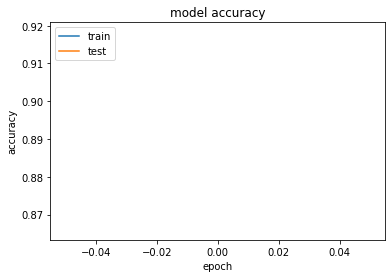

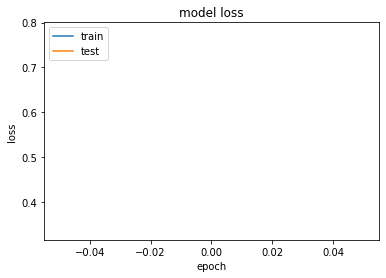

In [29]:
import matplotlib.pyplot as plt
# Fit the model
# list all data in history
print(results.history.keys())
# summarize history for accuracy
plt.plot(results.history['acc'])
plt.plot(results.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

3. seq2seq 기계 번역기 동작시키기

seq2seq는 훈련 과정(교사 강요)과 테스트 과정에서의 동작 방식이 다릅니다. 그래서 테스트 과정을 위해 모델을 다시 설계해주어야 합니다. 특히 디코더를 수정해야 합니다. 이번에는 번역 단계를 위해 모델을 수정하고 동작시켜보겠습니다.

전체적인 번역 단계를 정리하면 아래와 같습니다.

번역하고자 하는 입력 문장이 인코더로 입력되어 인코더의 마지막 시점의 은닉 상태와 셀 상태를 얻습니다.
인코더의 은닉 상태와 셀 상태, 그리고 토큰 <sos>를 디코더로 보냅니다.
디코더가 토큰 <eos>가 나올 때까지 다음 단어를 예측하는 행동을 반복합니다.
인코더의 입, 출력으로 사용하는 encoder_inputs와 encoder_states는 훈련 과정에서 이미 정의한 것들을 재사용합니다. 이렇게 되면 훈련 단계에 encoder_inputs와 encoder_states 사이에 있는 모든 층까지 전부 불러오게 되므로 결과적으로 훈련 단계에서 사용한 인코더를 그대로 재사용하게 됩니다. 이어서 디코더를 설계합니다. 테스트 단계에서는 디코더를 매 시점 별로 컨트롤 할 예정으로, 이를 위해서 이전 시점의 상태를 저장할 텐서인 decoder_state_input_h, decoder_state_input_c를 정의합니다. 매 시점 별로 디코더를 컨트롤하는 함수는 뒤에서 정의할 decode_sequence()로 해당 함수를 자세히 살펴봐야 합니다.

In [30]:
# 인코더
encoder_model = Model(encoder_inputs, encoder_states)

# 디코더 설계 시작
# 이전 시점의 상태를 보관할 텐서
decoder_state_input_h = Input(shape=(hidden_units,))
decoder_state_input_c = Input(shape=(hidden_units,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# 훈련 때 사용했던 임베딩 층을 재사용
dec_emb2 = dec_emb_layer(decoder_inputs)

# 다음 단어 예측을 위해 이전 시점의 상태를 현 시점의 초기 상태로 사용
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]

# 모든 시점에 대해서 단어 예측
decoder_outputs2 = decoder_dense(decoder_outputs2)

# 수정된 디코더
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs2] + decoder_states2)

테스트 단계에서의 동작을 위한 decode_sequence 함수를 구현합니다. 
입력 문장이 들어오면 인코더는 마지막 시점까지 전개하여 마지막 시점의 은닉 상태와 셀 상태를 리턴합니다. 
이 두 개의 값을 states_value에 저장합니다. 그리고 디코더의 초기 입력으로 <SOS>를 준비합니다. 이를 target_seq에 저장합니다. 
이 두 가지 입력을 가지고 while문 안으로 진입하여 이 두 가지를 디코더의 입력으로 사용합니다. 
이제 디코더는 현재 시점에 대해서 예측을 하게 되는데, 현재 시점의 예측 벡터가 output_tokens, 현재 시점의 은닉 상태가 h, 현재 시점의 셀 상태가 c입니다. 
예측 벡터로부터 현재 시점의 예측 단어인 target_seq를 얻고, h와 c 이 두 개의 값은 states_value에 저장합니다. 
그리고 while문의 다음 루프. 즉, 두번째 시점의 디코더의 입력으로 다시 target_seq와 states_value를 사용합니다. 
이를 현재 시점의 예측 단어로 <eos>를 예측하거나 번역 문장의 길이가 50이 넘는 순간까지 반복합니다.
 각 시점마다 번역된 어는 decoded_sentence에 누적하여 저장하였다가 최종 번역 시퀀스로 리턴합니다.


In [31]:


def decode_sequence(input_seq):
  # 입력으로부터 인코더의 마지막 시점의 상태(은닉 상태, 셀 상태)를 얻음
  states_value = encoder_model.predict(input_seq)

  # <SOS>에 해당하는 정수 생성
  target_seq = np.zeros((1,1))
  target_seq[0, 0] = tar_to_index['<sos>']

  stop_condition = False
  decoded_sentence = ''

  # stop_condition이 True가 될 때까지 루프 반복
  # 구현의 간소화를 위해서 이 함수는 배치 크기를 1로 가정합니다.
  while not stop_condition:
    # 이점 시점의 상태 states_value를 현 시점의 초기 상태로 사용
    output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

    # 예측 결과를 단어로 변환
    sampled_token_index = np.argmax(output_tokens[0, -1, :])
    sampled_char = index_to_tar[sampled_token_index]

    # 현재 시점의 예측 단어를 예측 문장에 추가
    decoded_sentence += ' '+sampled_char

    # <eos>에 도달하거나 정해진 길이를 넘으면 중단.
    if (sampled_char == '<eos>' or
        len(decoded_sentence) > 50):
        stop_condition = True

    # 현재 시점의 예측 결과를 다음 시점의 입력으로 사용하기 위해 저장
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = sampled_token_index

    # 현재 시점의 상태를 다음 시점의 상태로 사용하기 위해 저장
    states_value = [h, c]

  return decoded_sentence

In [32]:
# 결과 확인을 위한 함수를 만듭니다. 
# seq_to_src 함수는 영어 문장에 해당하는 정수 시퀀스를 입력받으면 정수로부터 영어 단어를 리턴하는 index_to_src를 통해 영어 문장으로 변환합니다.
# seq_to_tar은 프랑스어에 해당하는 정수 시퀀스를 입력받으면 정수로부터 프랑스어 단어를 리턴하는 index_to_tar을 통해 프랑스어 문장으로 변환합니다.

# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq_to_src(input_seq):
  sentence = ''
  for encoded_word in input_seq:
    if(encoded_word != 0):
      sentence = sentence + index_to_src[encoded_word] + ' '
  return sentence

# 번역문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq_to_tar(input_seq):
  sentence = ''
  for encoded_word in input_seq:
    if(encoded_word != 0 and encoded_word != tar_to_index['<sos>'] and encoded_word != tar_to_index['<eos>']):
      sentence = sentence + index_to_tar[encoded_word] + ' '
  return sentence

In [33]:
# 훈련 데이터에 대해서 임의로 선택한 인덱스의 샘플의 결과를 출력해봅시다.

for seq_index in [3, 50, 100, 300, 1001]:
  input_seq = encoder_input_train[seq_index: seq_index + 1]
  decoded_sentence = decode_sequence(input_seq)

  print("입력문장 :",seq_to_src(encoder_input_train[seq_index]))
  print("정답문장 :",seq_to_tar(decoder_input_train[seq_index]))
  print("번역문장 :",decoded_sentence[1:-5])
  print("-"*50)

입력문장 : can i sing ? 
정답문장 : puis je chanter ? 
번역문장 : puis je demander a tom ? 
--------------------------------------------------
입력문장 : i m poor at tennis . 
정답문장 : je suis mediocre au tennis . 
번역문장 : je suis mediocre au tennis . 
--------------------------------------------------
입력문장 : you nearly died . 
정답문장 : vous etes presque morte . 
번역문장 : vous etes presque mort . 
--------------------------------------------------
입력문장 : do you feel lucky ? 
정답문장 : te sens tu chanceux ? 
번역문장 : vous sentez vous en veine ? 
--------------------------------------------------
입력문장 : we waited outside . 
정답문장 : nous avons attendu dehors . 
번역문장 : nous attendimes dehors . 
--------------------------------------------------


In [34]:
# 테스트 데이터에 대해서 임의로 선택한 인덱스의 샘플의 결과를 출력해봅시다.

for seq_index in [3, 50, 100, 300, 1001]:
  input_seq = encoder_input_test[seq_index: seq_index + 1]
  decoded_sentence = decode_sequence(input_seq)

  print("입력문장 :",seq_to_src(encoder_input_test[seq_index]))
  print("정답문장 :",seq_to_tar(decoder_input_test[seq_index]))
  print("번역문장 :",decoded_sentence[1:-5])
  print("-"*50)

입력문장 : you re conceited . 
정답문장 : vous etes suffisants . 
번역문장 : vous etes suffisante . 
--------------------------------------------------
입력문장 : he is in trouble . 
정답문장 : il a des ennuis . 
번역문장 : il a la baraka . 
--------------------------------------------------
입력문장 : tom tried to sleep . 
정답문장 : tom essaya de dormir . 
번역문장 : tom a parle de marie . 
--------------------------------------------------
입력문장 : i dozed . 
정답문장 : je me suis assoupi . 
번역문장 : j ai vu . 
--------------------------------------------------
입력문장 : i ve been tricked . 
정답문장 : on m a trompe . 
번역문장 : j ai ete expulse . 
--------------------------------------------------
